In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from util import *

ratings, movies, genres = read_files()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
ratings.head(),None, movies.head()

(   userId  movieId  rating  timestamp
 0       1        1     4.0  964982703
 1       1        3     4.0  964981247
 2       1        6     4.0  964982224
 3       1       47     5.0  964983815
 4       1       50     5.0  964982931,
 None,
    movieId                               title  \
 0        1                    Toy Story (1995)   
 1        2                      Jumanji (1995)   
 2        3             Grumpier Old Men (1995)   
 3        4            Waiting to Exhale (1995)   
 4        5  Father of the Bride Part II (1995)   
 
                                         genres  Drama  Adventure  Animation  \
 0  Adventure|Animation|Children|Comedy|Fantasy  False       True       True   
 1                   Adventure|Children|Fantasy  False       True      False   
 2                               Comedy|Romance  False      False      False   
 3                         Comedy|Drama|Romance   True      False      False   
 4                                       Comedy  F

# Macierz użyteczności

Ocena filmu przez użytkownika

In [14]:
utility_matrix = coo_matrix((ratings['rating'], (ratings['userId'], ratings['movieId']))).asfptype()
utility_matrix.toarray(), utility_matrix.toarray().shape

(array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 4. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 2.5, 2. , ..., 0. , 0. , 0. ],
        [0. , 3. , 0. , ..., 0. , 0. , 0. ],
        [0. , 5. , 0. , ..., 0. , 0. , 0. ]]), (611, 193610))

In [15]:
# x = np.array((utility_matrix.T @ utility_matrix).sum(axis=0)[:, movies["movieId"]])[0]
# for g in genres:
#     fig, ax = plt.subplots()
#     plt.title(g)
#     scatter = ax.scatter(x, x, c = movies[g])
#     legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower right", title="Classes")
#     ax.add_artist(legend1)
#     plt.show()
# 

In [16]:
# plt.figure(figsize=(10,600))
# plt.imshow(utility_matrix.toarray()[:, movies["movieId"]].T)
# 

In [17]:
# pca_model = PCA(n_components=2)
# pca = pca_model.fit_transform(utility_matrix.toarray()[:, movies["movieId"]].T)
# for g in genres:
#     fig, ax = plt.subplots()
#     plt.title(g)
#     scatter = ax.scatter(pca[:, 0], pca[:, 1], c = movies[g])
#     legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="upper right", title="Classes")
#     ax.add_artist(legend1)
#     plt.show()

In [18]:
# clf = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, utility_matrix.toarray()[:, movies["movieId"]].T, movies["Action"], cv=10)
# export_tree(clf, range(X.shape[1]), "cross_val.pdf")


In [19]:
Tree_data = pd.DataFrame(
        data=utility_matrix.toarray()[:, movies["movieId"]].T,
        # index=movies["movieId"],
        columns=[f"user_{x}" for x in range(utility_matrix.shape[0])]

)
# movies.shape, utility_matrix.toarray()[:, movies["movieId"]].T.shape
# print(Tree_data.shape, movies[list(genres)].shape, movies["mean"].shape)
Tree_data[list(genres)] = movies[list(genres)]
Tree_data['mean'] = movies['mean']
Tree_data = Tree_data.fillna(0)
Tree_data.head()

,user_0,user_1,user_2,user_3,user_4,user_5,user_6,user_7,user_8,user_9,...,Film-Noir,Crime,Romance,Musical,War,Mystery,IMAX,Comedy,Fantasy,mean
0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,...,False,False,False,False,False,False,False,True,True,3.920930
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,...,False,False,False,False,False,False,False,False,True,3.431818
2,0.0,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,3.259615
3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,False,False,True,False,False,False,False,True,False,2.357143
4,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,True,False,3.071429


In [23]:
data = {}
for genre in genres:
    clf = tree.DecisionTreeClassifier(
            max_depth=30, 
            min_samples_split=20, 
            min_samples_leaf=10, 
            min_impurity_decrease=0.0001, 
            class_weight='balanced'
            )
    
    # genre = 'Animation'
    X = Tree_data.drop(genre, axis=1)
    y = Tree_data[genre]
    clf = clf.fit(X, y)
    score_val = np.sum(cross_val_score(clf, X, y, cv=10))/10
    # print(f"""{genre}:
    # Quentity: {len(y[Tree_data[genre] == True])} / {len(y[Tree_data[genre] != True])}
    # True positives: {clf.score(X[Tree_data[genre] == True], y[Tree_data[genre] == True])}
    # Accuracy: {clf.score(X, y)}
    # Cross-val: {score_val}"""
    #         )
    data[genre] = [len(y[Tree_data[genre] == True]), score_val]
    # export_tree(clf, X.columns, f"custom_{genre}.pdf")

In [66]:
# clf = tree.DecisionTreeClassifier(max_depth=30, min_samples_split=20, min_samples_leaf=10, )
# clf = clf.fit(Tree_data.drop(genres, axis=1), y)
# print(clf.score(Tree_data.drop(genres, axis=1), y))
# export_tree(clf, Tree_data.drop(genres, axis=1).columns, "custom2.pdf")

0.8677889550400328


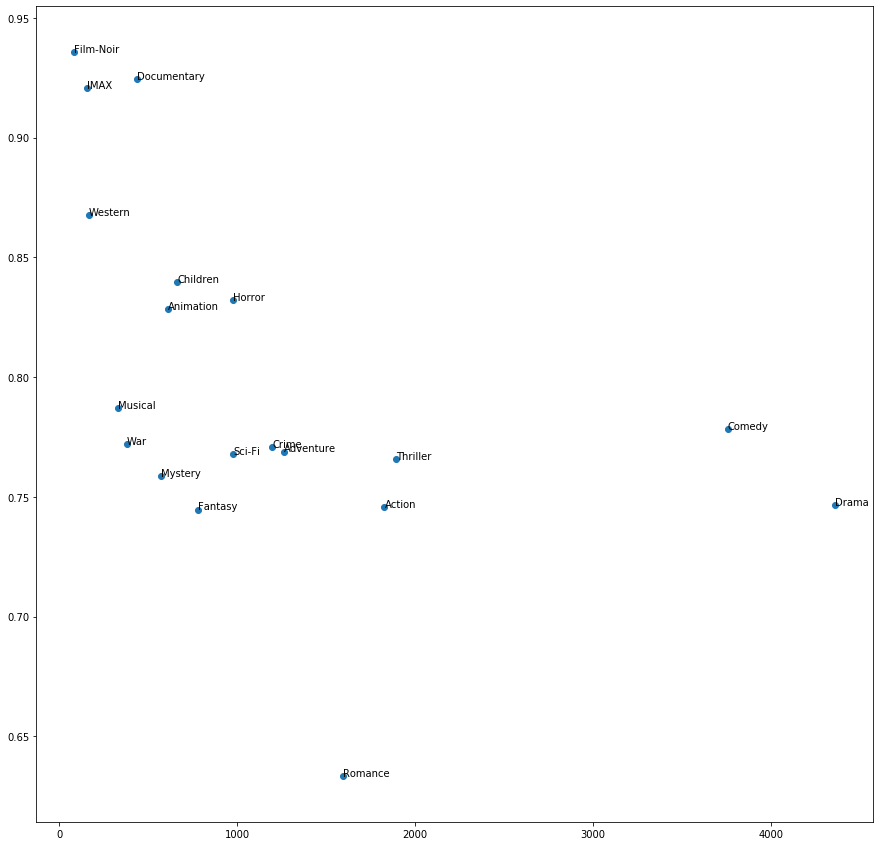

In [29]:
fig, ax = plt.subplots(figsize=(15,15))
v1, v2 = list(zip(*data.values()))
ax.scatter(v1, v2)

for i, txt in enumerate(data.keys()):
    ax.annotate(txt, (v1[i], v2[i]))

